# Домашнее задание №10
## Логистическая регрессия. Часть 1.
### PROC LOGISTIC

_[Укажите в данной ячейке ФИО всех участников вашей группы - от 1 до 3 человек]_

Пучкин Данила Андреевич

### 0. Подготовка файлов для выполнения ДЗ.

- НАБОР ДАННЫХ ДЛЯ ЗАДАНИЯ: HW10_DATA.csv (в слайдах на лекции он назывался 'develop', там же можно посмотреть список переменных)

Ответьте на вопросы ниже, не забудьте указать все, на что Вы обратили внимание, отвечая на вопрос, делая соответствующие выводы (график/таблицу/статистику/p-value/прочее).

In [34]:
libname dev '/folders/myfolders/HW10';

In [35]:
proc import file="/folders/myfolders/HW10/HW10_DATA.csv"
        out=develop
        DBMS=CSV
        REPLACE;
run;

proc print data=develop (obs=5); run;

Obs,AcctAge,DDA,DDABal,CashBk,Checks,DirDep,NSF,NSFAmt,Phone,Teller,Sav,SavBal,ATM,ATMAmt,POS,POSAmt,CD,CDBal,IRA,IRABal,LOC,LOCBal,ILS,ILSBal,MM,MMBal,MMCred,MTG,MTGBal,CC,CCBal,CCPurc,SDB,Income,HMOwn,LORes,HMVal,Age,CRScore,Moved,InArea,Ins,Branch,Res,Dep,DepAmt,Inv,InvBal
1,0.3,1,419.27,0,0,0,0,0,0,0,1,10233.72,1,106.74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,483.65,0,0,16,1,11,89,63,696,0,1,1,B17,R,2,1170.06,0,0
2,0.7,1,1986.81,0,1,1,0,0,0,0,0,0,1,268.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,4,1,7,87,51,674,0,1,0,B2,R,1,446.93,0,0
3,4.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,30,1,8.5,97,60,640,0,1,1,B3,S,0,0,0,0
4,0.5,1,1594.84,0,1,0,0,0,0,1,1,425.06,1,278.07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65.76,0,0,125,1,7.5,145,44,672,0,1,0,B1,S,1,1144.24,0,0
5,6.7,1,2813.45,0,2,0,0,0,0,5,1,2716.55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,1,6,101,46,648,0,1,1,B1,S,2,1208.94,0,0


In [36]:
/* Зависимая переменная/Целевая переменная для анализа */
%let ORIG_TARGET=Ins;

/* Предикторы/входные переменные/независимые переменные для анализа */
%let ORIG_INPUTS=AcctAge DDA DDABal 
    CashBk Checks DirDep NSF NSFAmt Phone 
    Teller Sav SavBal ATM ATMAmt POS POSAmt 
    CD CDBal IRA IRABal LOC LOCBal ILS 
    ILSBal MM MMBal MMCred MTG MTGBal CC 
    CCBal CCPurc SDB Income HMOwn LORes 
    HMVal Age CRScore Moved InArea Branch 
    Res Dep DepAmt Inv InvBal;
    
%let ALL_VARS=AcctAge DDA DDABal 
    CashBk Checks DirDep NSF NSFAmt Phone 
    Teller Sav SavBal ATM ATMAmt POS POSAmt 
    CD CDBal IRA IRABal LOC LOCBal ILS 
    ILSBal MM MMBal MMCred MTG MTGBal CC 
    CCBal CCPurc SDB Income HMOwn LORes 
    HMVal Age CRScore Moved InArea Ins Branch 
    Res Dep DepAmt Inv InvBal;
        
/* Данные для анализа */
%let DS=develop;

### Задание


### 1. Предварительное  исследование данных  
#### 1.1 Посмотрите на статистики и распределения переменных.

In [37]:
proc corr data=develop nocorr plots=none; run;


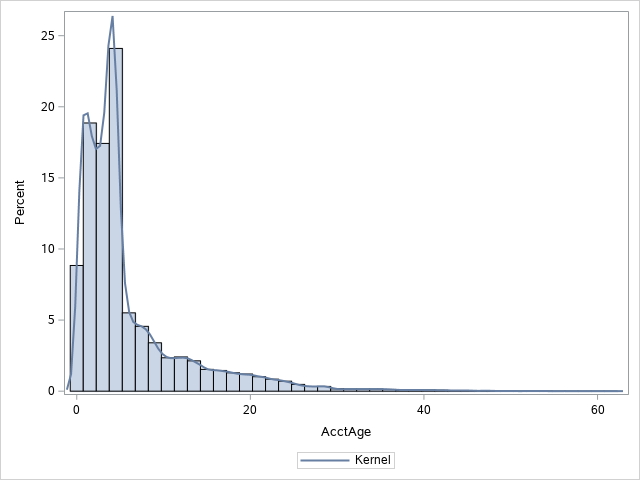
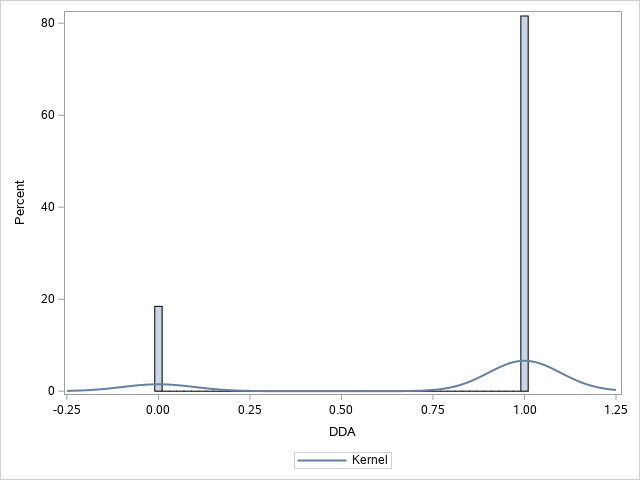
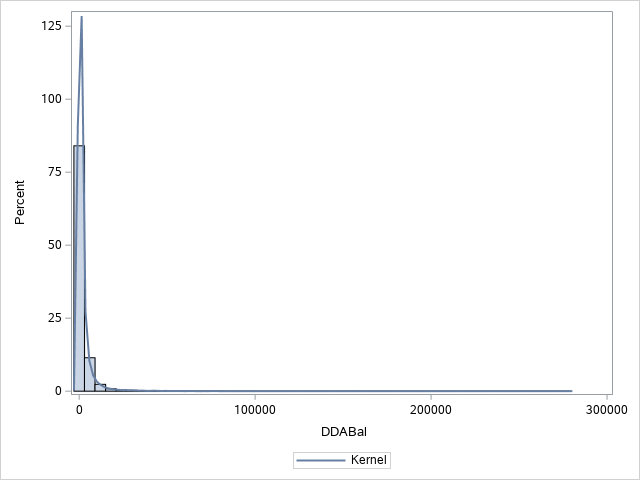
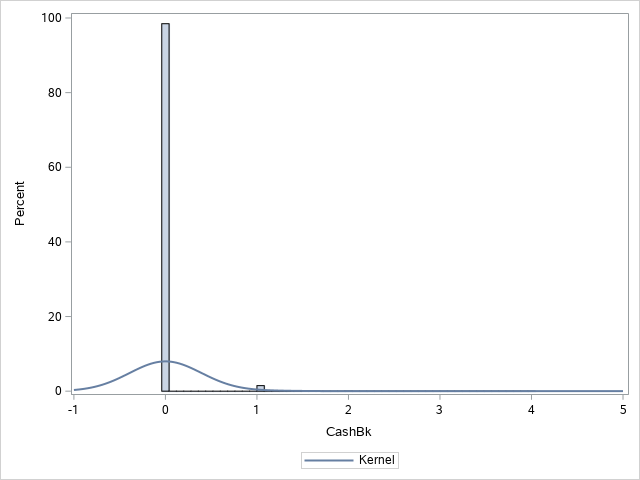
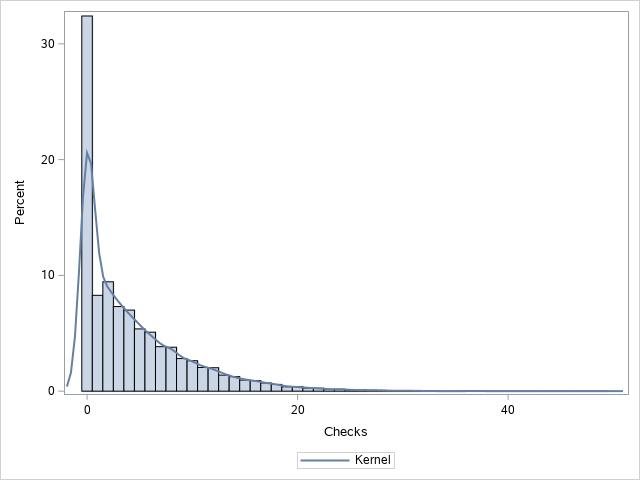
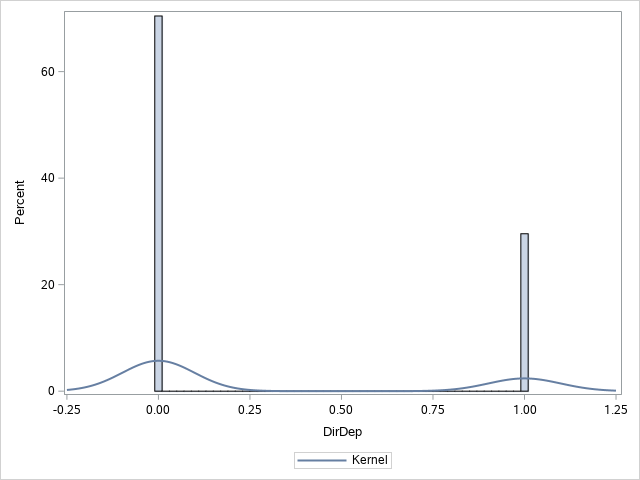
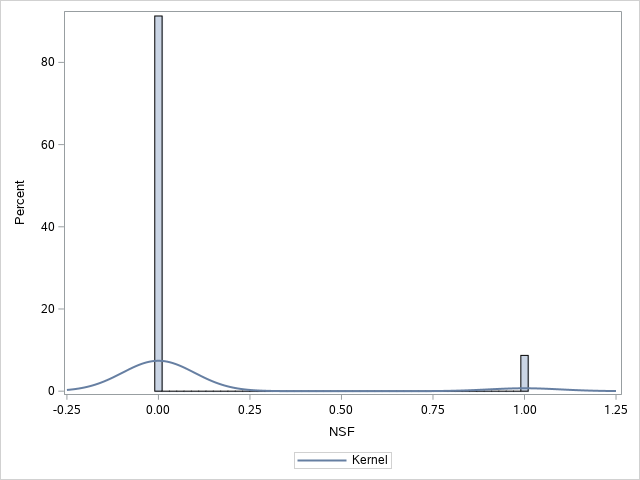
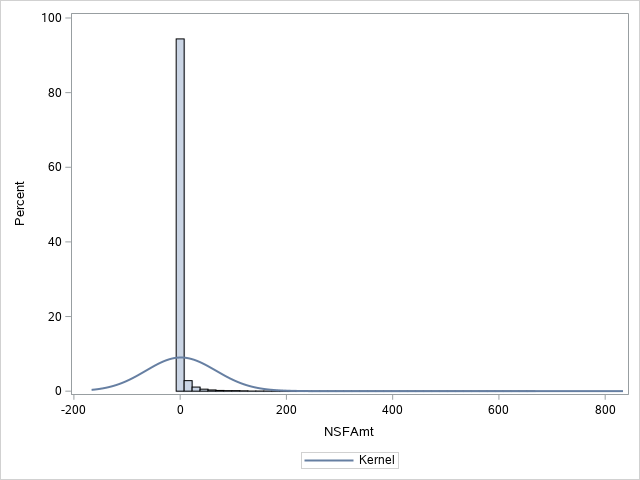
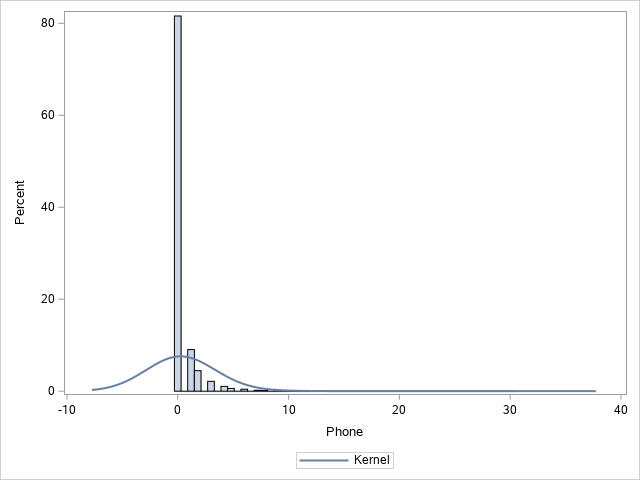
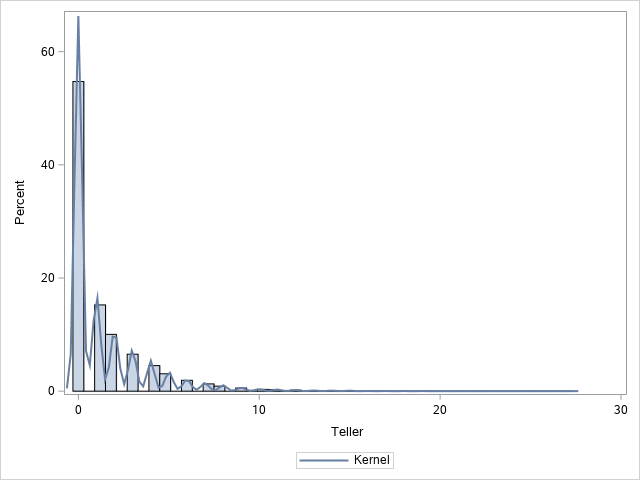
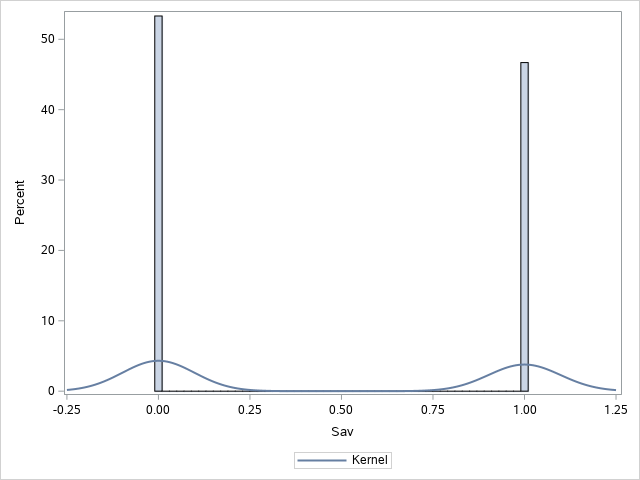
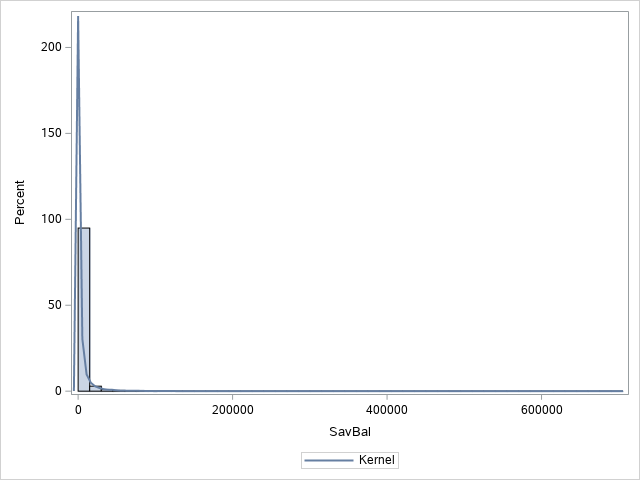
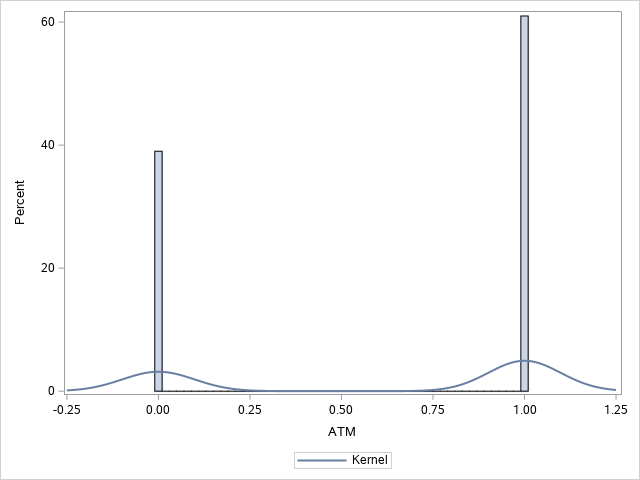
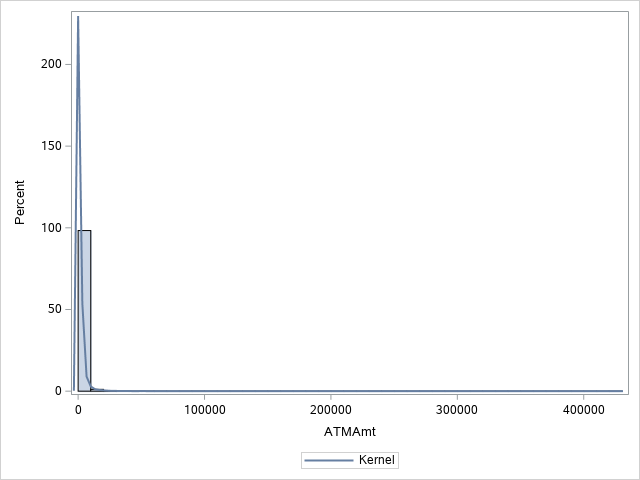
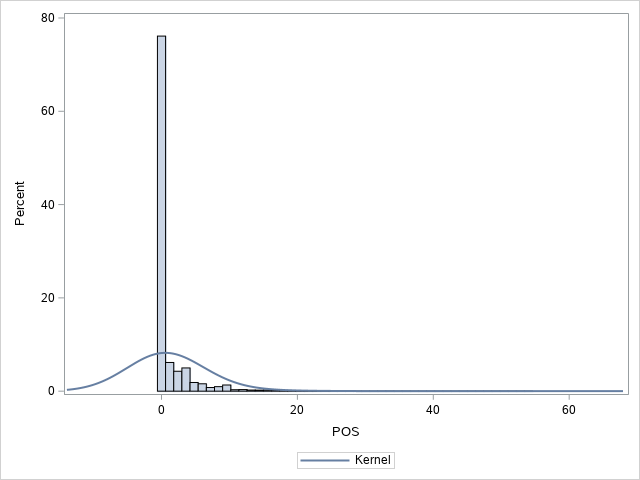
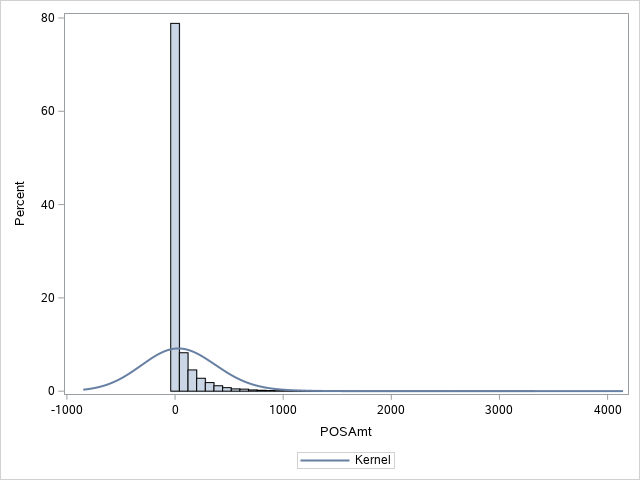
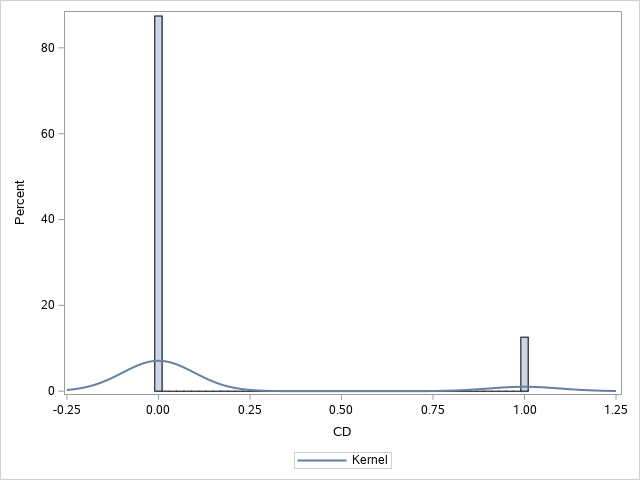
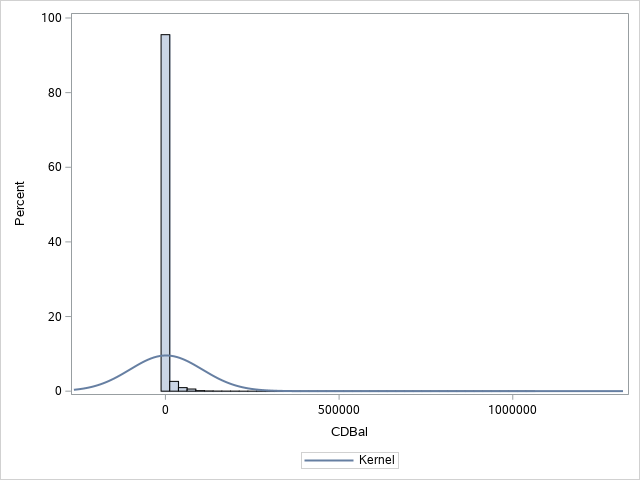
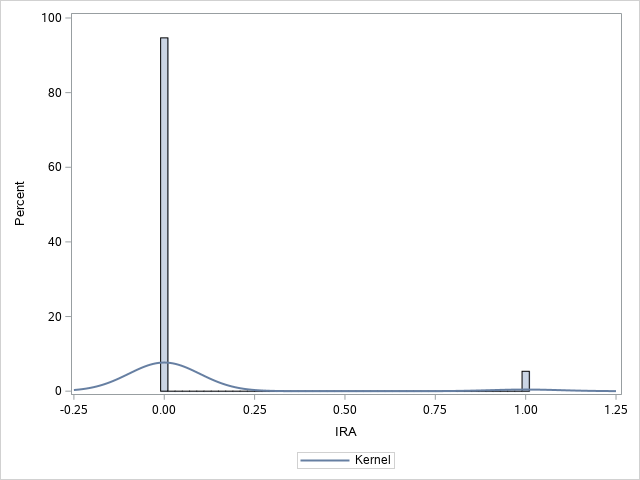
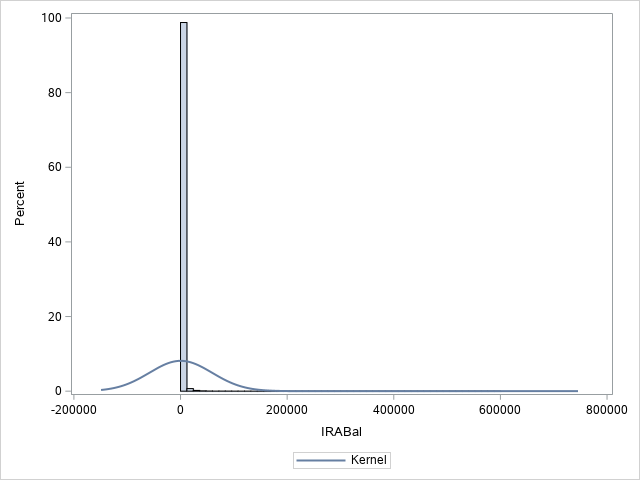
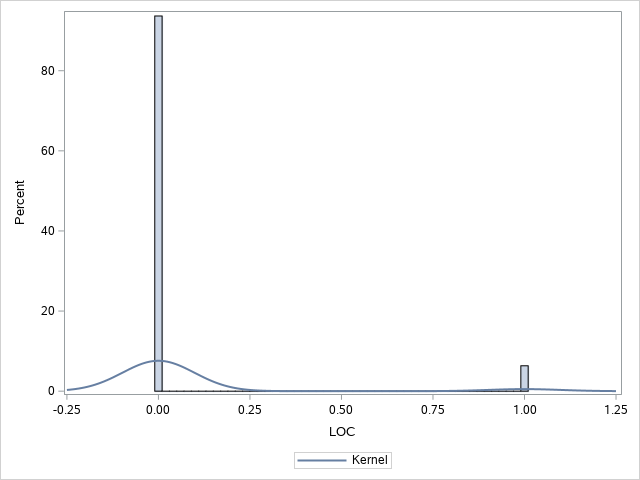
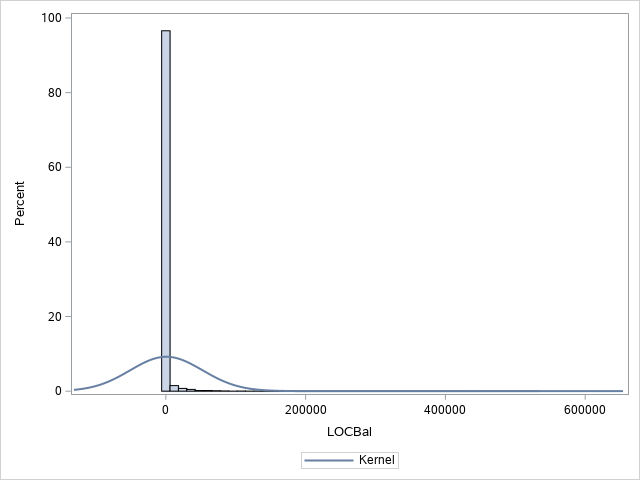
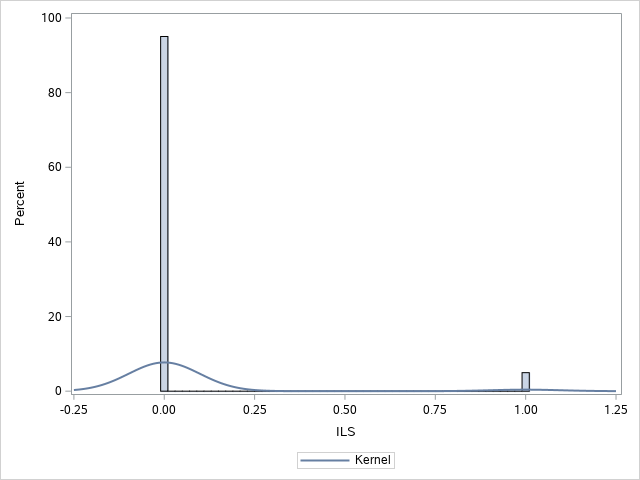
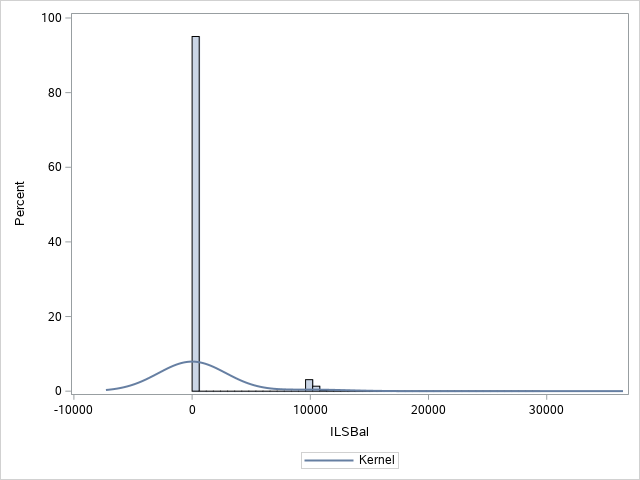
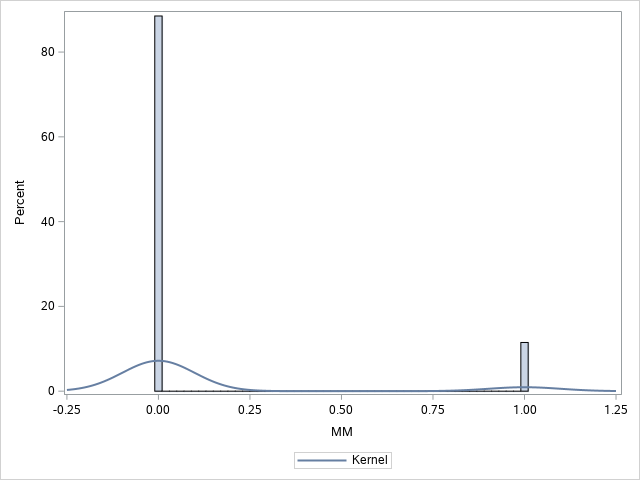
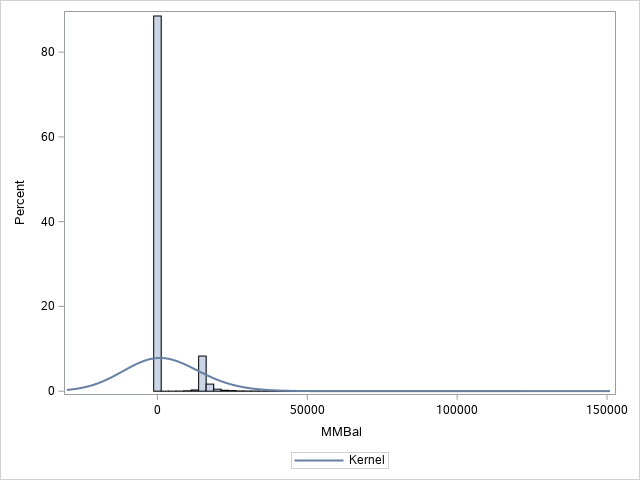
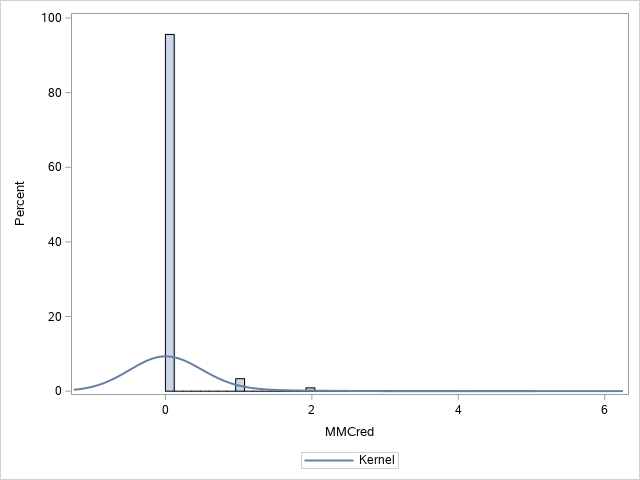
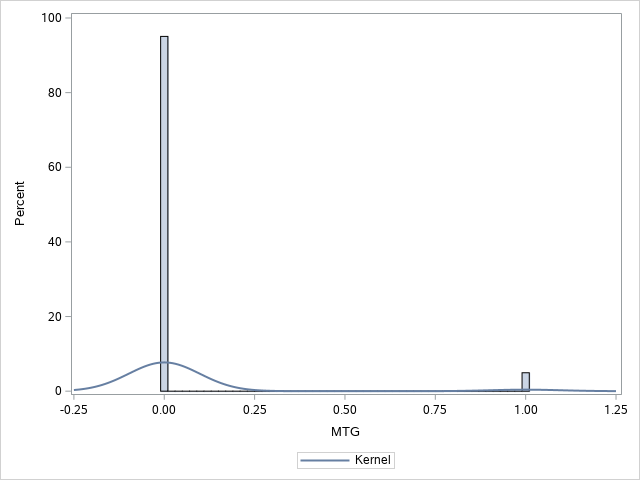
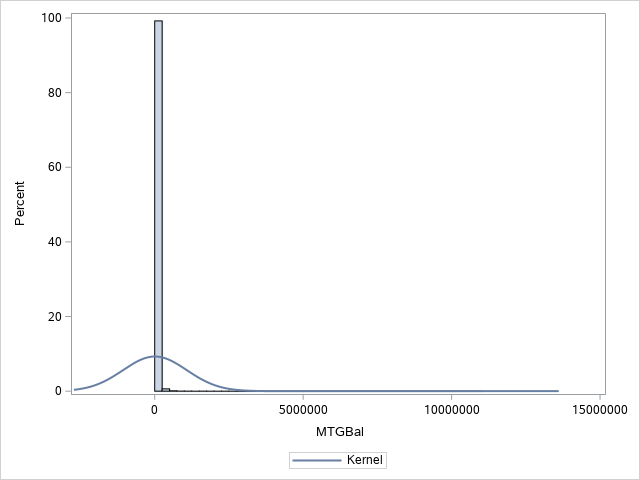
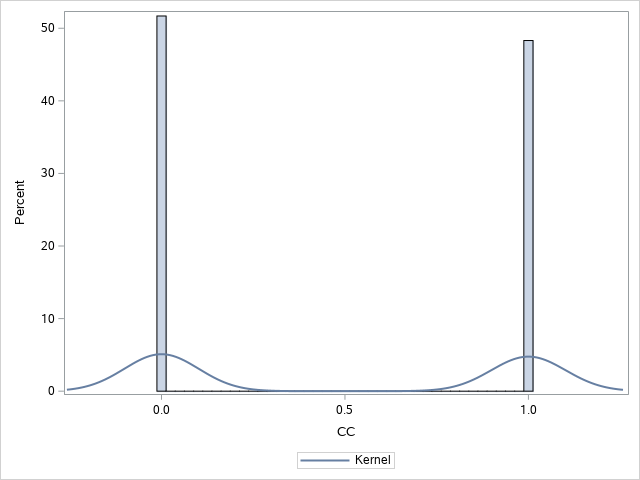
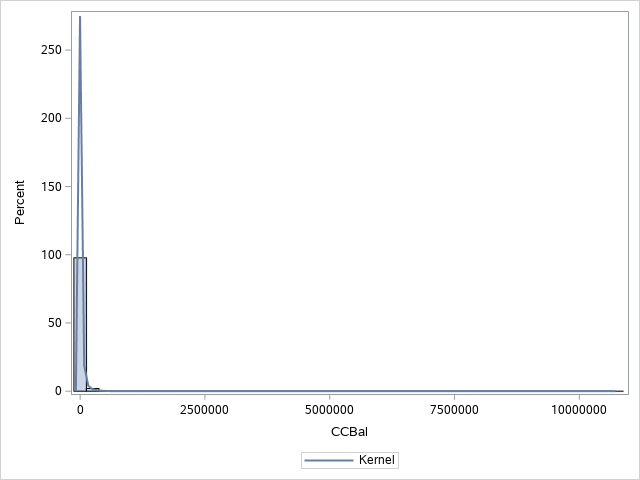
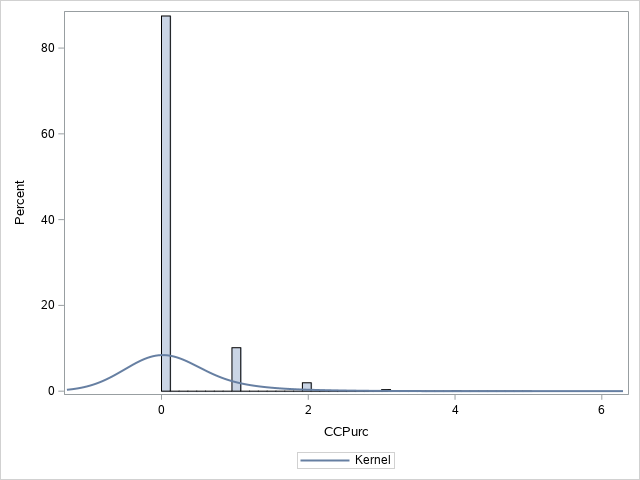
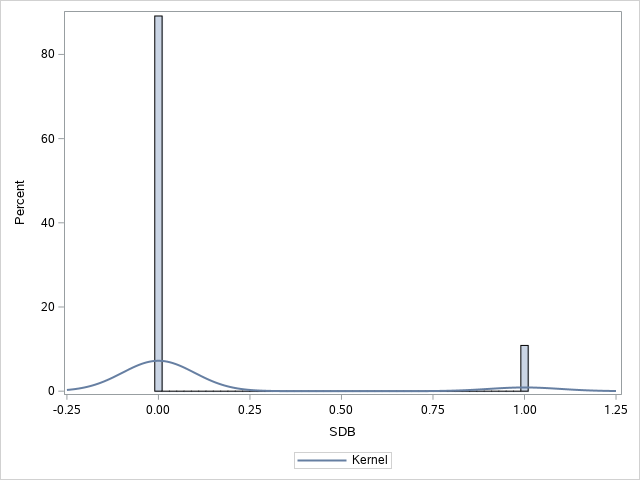
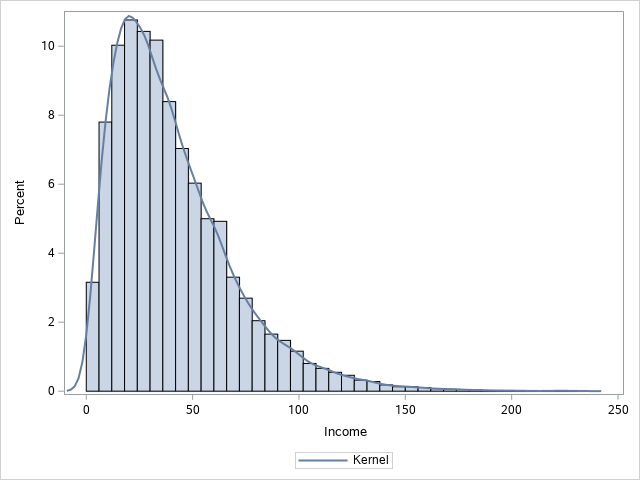
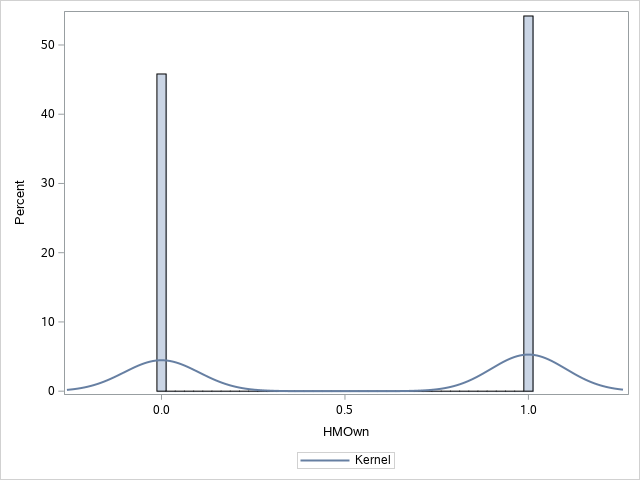
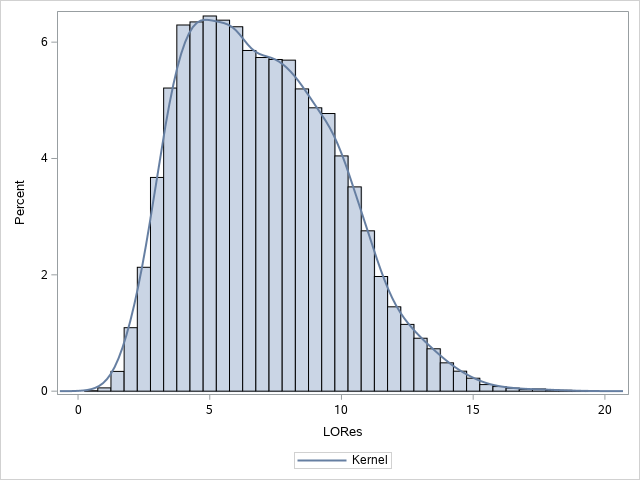
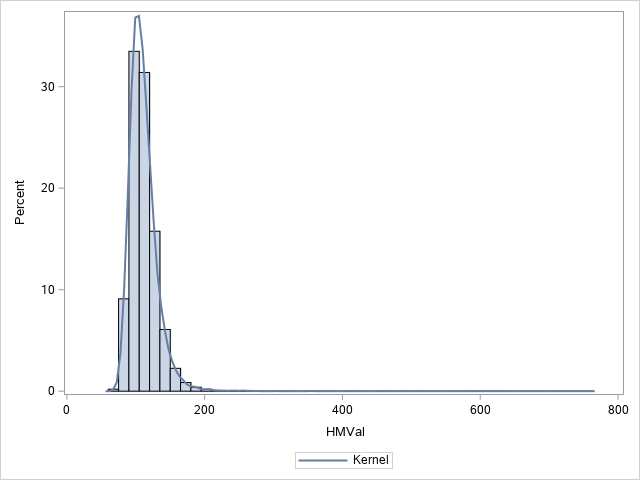
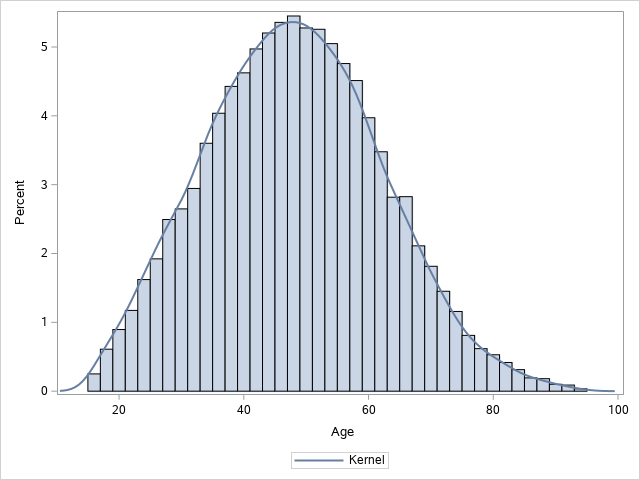
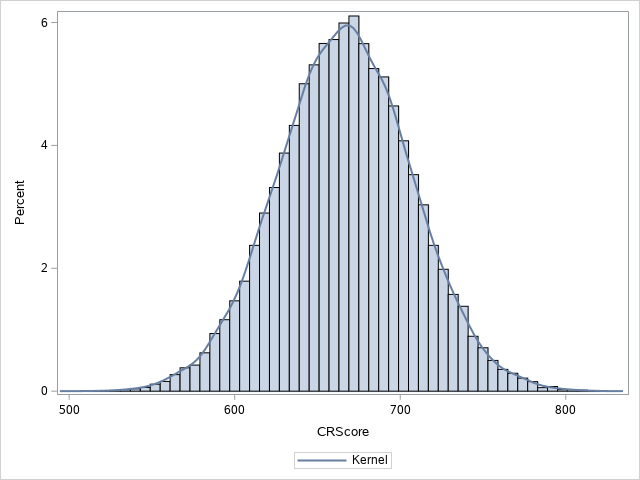
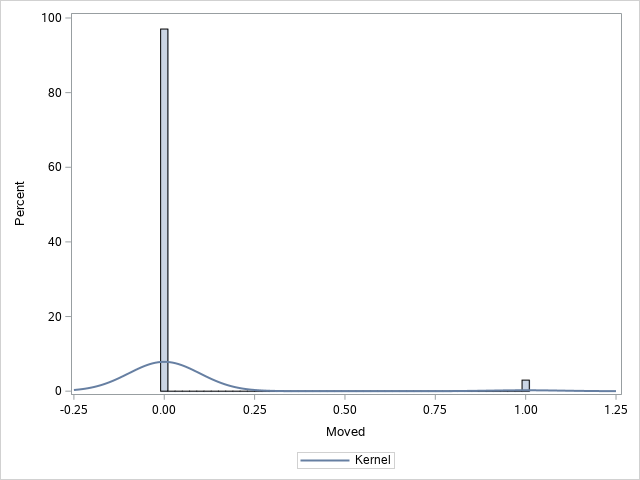
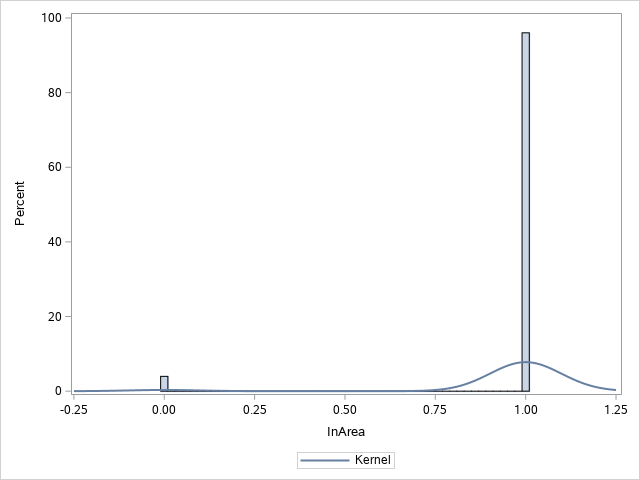
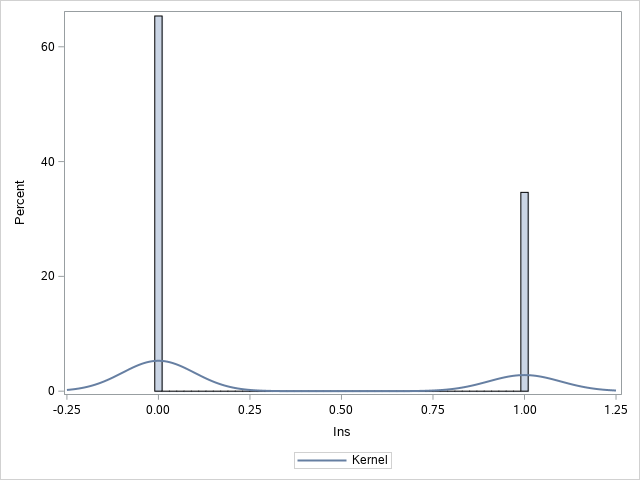
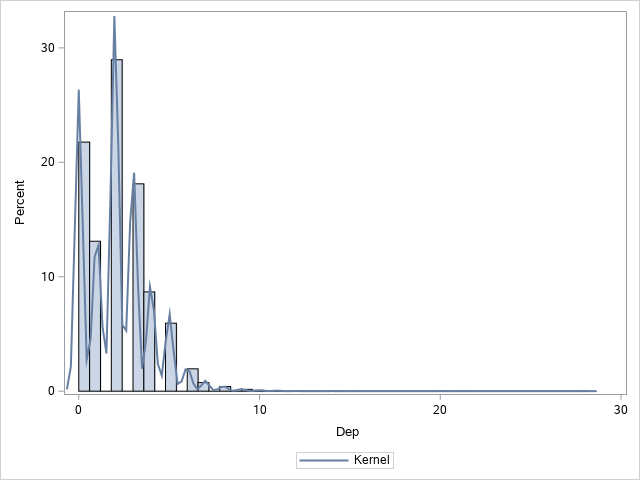
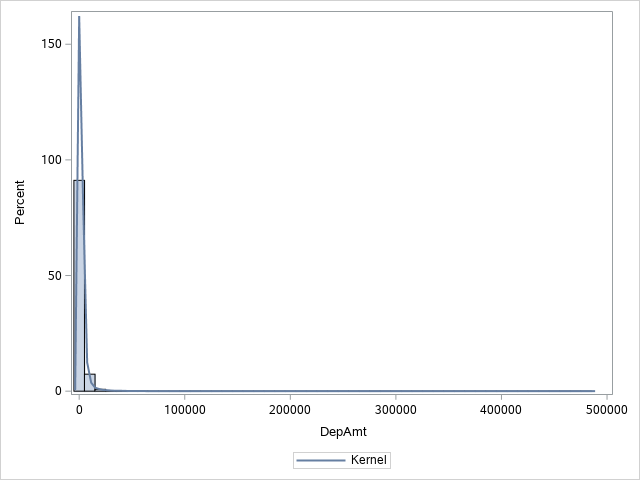
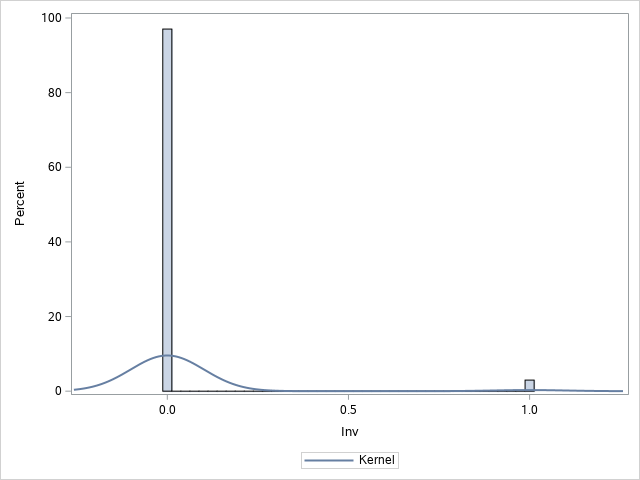
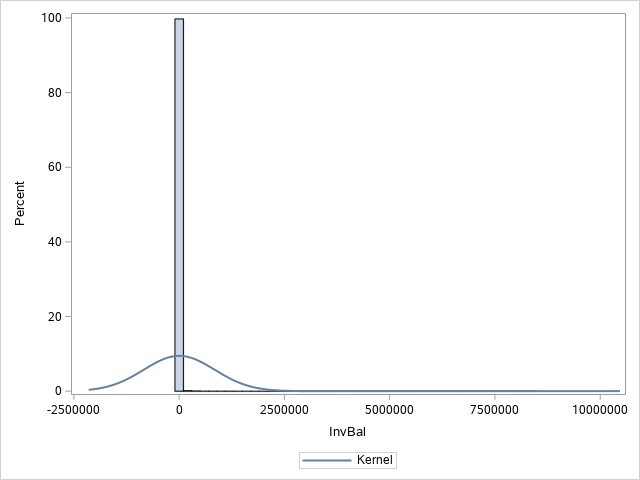

In [38]:
%macro plotall(list);
    %let argnum = 1;
    %let arg = %scan(&list, &argnum, %str( ));
    
    %do %while (&arg NE );
        proc sgplot data=&DS;
            histogram &arg;
            density &arg / type=kernel;
        run;
        %let argnum=%eval(&argnum+1);
        %let arg = %scan(&list, &argnum, %str( ));
    %end;
%mend;

%plotall(&ALL_VARS);

#### Q1.1: Укажите все переменные, в которых встречаются пропущенные значения:
...

AcctAge, Phone, POS, POSAmt, CC, CCBal, CCPurc, Income, HMOwn, LORes, HMVal, Age, CRScore, Inv, InvBal

#### 1.2 Разделите набор на две части: train и test. 
Далее всю разработку мы проводим на части train, а к test мы применяем полученный результат. См. ex_train_val.sas

In [39]:
/* Ваш код для выполнения задания (не забудьте запустить его) */
/* Sort the data by the target   */
/* in preparation for stratified */
/* sampling.                     */
proc sort data=develop; 
   by ins; 
run;

/* The SURVEYSELECT procedure will  */
/* perform stratified sampling on   */
/* any variable in the STRATA       */
/* statement.  The OUTALL option    */
/* specifies that you want a flag   */
/* appended to the file to indicate */
/* selected records, not simply a   */
/* file comprised of the selected   */
/* records.                         */
proc surveyselect noprint ranuni
                  data = develop 
                  samprate=.6667 /*train ~66%, test ~33%*/
                  out=develop1
                  seed=44444
                  outall;
   strata ins;
run;

proc print data=develop1 (obs=10);
run;

Obs,Selected,Ins,AcctAge,DDA,DDABal,CashBk,Checks,DirDep,NSF,NSFAmt,Phone,Teller,Sav,SavBal,ATM,ATMAmt,POS,POSAmt,CD,CDBal,IRA,IRABal,LOC,LOCBal,ILS,ILSBal,MM,MMBal,MMCred,MTG,MTGBal,CC,CCBal,CCPurc,SDB,Income,HMOwn,LORes,HMVal,Age,CRScore,Moved,InArea,Branch,Res,Dep,DepAmt,Inv,InvBal,SelectionProb,SamplingWeight
1,1,0,0.7,1,1986.81,0,1,1,0,0,0,0,0,0,1,268.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,4,1,7,87,51,674,0,1,B2,R,1,446.93,0,0,0.66675,1.49982
2,1,0,0.5,1,1594.84,0,1,0,0,0,0,1,1,425.06,1,278.07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65.76,0,0,125,1,7.5,145,44,672,0,1,B1,S,1,1144.24,0,0,0.66675,1.49982
3,1,0,8.8,1,1437.57,0,12,1,0,0,0,0,0,0,1,391.63,0,0,0,0,0,0,0,0,0,0,0,0,0,1,94539.95,1,85202.99,0,0,55,1,3.5,128,57,659,0,1,B1,U,2,2237.69,0,0,0.66675,1.49982
4,1,0,0.8,1,190.03,0,1,0,1,5.65,.,0,1,11.47,1,1582.34,.,.,0,0,0,0,0,0,0,0,0,0,0,0,0,.,.,.,1,20,0,4,107,40,642,0,1,B14,S,3,880.25,.,.,0.66675,1.49982
5,1,0,3,1,1772.13,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,1,7.5,95,29,612,0,1,B4,U,2,1143.44,0,0,0.66675,1.49982
6,1,0,14.3,1,1226.9,0,12,0,0,0,.,2,0,0,1,779.72,.,.,0,0,0,0,0,0,0,0,0,0,0,0,0,.,.,.,1,102,1,5,146,34,711,0,1,B19,R,3,2321.8,.,.,0.66675,1.49982
7,1,0,1.6,1,257.13,0,14,0,1,60.25,.,1,1,9.8,1,3807.19,.,.,1,7500,0,0,0,0,0,0,0,0,0,0,0,.,.,.,0,24,1,8.5,95,54,732,0,1,B15,U,5,3408.35,.,.,0.66675,1.49982
8,1,0,.,1,375.62,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,1,12,91,58,662,0,1,B16,R,1,778.34,0,0,0.66675,1.49982
9,1,0,4.8,1,324.94,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,100,1,13,135,75,715,0,1,B9,S,0,0,0,0,0.66675,1.49982
10,0,0,1.8,1,13.85,0,0,0,0,0,0,0,1,426.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,323.13,0,0,13,1,10,77,51,679,0,1,B7,U,1,25.84,0,0,0.66675,0.00000



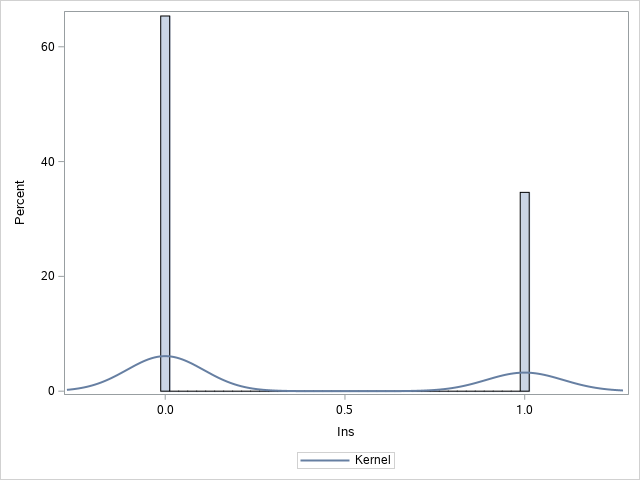
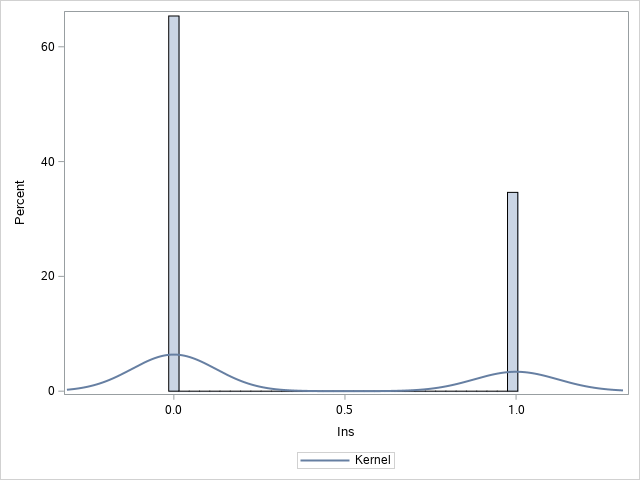

In [40]:
data train;
    set develop1;
    where Selected=1;
    output train;
run;

data test;
    set develop1;
    where Selected=0;
    output test;
run;

proc sgplot data=train;
    histogram ins;
    density ins / type=kernel;
run;

proc sgplot data=test;
    histogram ins;
    density ins / type=kernel;
run;

#### Q1.2: Можно ли утверждать, что распределение целевой переменной в частях train и test почти одинаковое? 
...

Можно, судя по гистограммам и процессу разделения выборки

#### Q1.3: Какой оператор контролирует похожесть распределения? 
...

Происходит стратифицирование выборки по целевой переменной - strata ins

### 2. Выбор моделей кандидатов

#### 2.1 Выберите 2 модели, используя метод all subsets regression (и Хи-квадрат как метрику качества).

In [41]:
/* Ваш код для выполнения задания (не забудьте запустить его) */
proc logistic data=train;
    
    model ins(event='1') = AcctAge DDA DDABal 
    CashBk Checks DirDep NSF NSFAmt Phone 
    Teller Sav SavBal ATM ATMAmt POS POSAmt 
    CD CDBal IRA IRABal LOC LOCBal ILS 
    ILSBal MM MMBal MMCred MTG MTGBal CC 
    CCBal CCPurc SDB Income HMOwn LORes 
    HMVal Age CRScore Moved InArea Dep DepAmt Inv InvBal
    / selection=SCORE best=3 start=1 stop=45;
run;

In [42]:
proc logistic data=train;
    model ins(event='1') = DDA DDABal 
    CashBk Checks DirDep NSF NSFAmt
    Teller Sav SavBal ATM ATMAmt
    CD CDBal IRA IRABal LOC LOCBal ILS 
    ILSBal MM MMBal MMCred MTG MTGBal
    SDB Moved InArea Dep DepAmt
    / selection=SCORE best=3 start=1 stop=30;
run;

#### Q2.1 Почему вы выбрали их? + Q2.2 Какие переменные вошли в модели, которые вы выбрали?
...

При удалении переменных с пропещунными значениями метрика хи-квадрат перестает сильно расти при переходе через 6 переменных, поэтому выбраны модели на следующих переменных (встреченных до 6): CD, DDA SavBal, MM, MMBal, DDABal Sav. Скорее всего, перемнные MM и MMBal коррелируют (так как клчаются в модели не вместе), поэтому разделим их:

1. DDA DDABal Sav SavBal CD MM
2. DDA DDABal Sav SavBal CD MMBal

Заметим, что эти же переменные угадываются и без удаления переменных с пропущенными значениями

#### 2.2 Исследование выбранных моделей.

 - Постройте выбранные модели (т.е. оцените коэффициенты при переменных). 
 - Примените их к набору test. 
 - Постройте K-S (`PROC NPAR1WAY`) и ROC (`PROC LOGISTIC`) на наборах train и test. Оцените «устойчивость» модели. (см. ex_KS.sas и ex_ROC_comp.sas)


In [48]:
/* Ваш код для выполнения задания (не забудьте запустить его) */
proc logistic data=train;
    model ins(event='1') = DDA DDABal Sav SavBal CD MM;
    code file = '/folders/myfolders/HW10/model1.sas';
run;
proc logistic data=train;
    model ins(event='1') = DDA DDABal Sav SavBal CD MMBal;
    code file = '/folders/myfolders/HW10/model2.sas';
run;

In [60]:
data res1;
    set test;
    %include '/folders/myfolders/HW10/model1.sas';
run;

data res2;
    set test;
    %include '/folders/myfolders/HW10/model2.sas';
run;

proc print data=res1 (obs=5); run;

Obs,Selected,Ins,AcctAge,DDA,DDABal,CashBk,Checks,DirDep,NSF,NSFAmt,Phone,Teller,Sav,SavBal,ATM,ATMAmt,POS,POSAmt,CD,CDBal,IRA,IRABal,LOC,LOCBal,ILS,ILSBal,MM,MMBal,MMCred,MTG,MTGBal,CC,CCBal,CCPurc,SDB,Income,HMOwn,LORes,HMVal,Age,CRScore,Moved,InArea,Branch,Res,Dep,DepAmt,Inv,InvBal,SelectionProb,SamplingWeight,I_Ins,U_Ins,P_Ins1,P_Ins0
1,0,0,1.8,1,13.85,0,0,0,0,0,0,0,1,426.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,323.13,0,0,13,1,10,77,51,679,0,1,B7,U,1,25.84,0,0,0.66675,0,0,0,0.25693,0.74307
2,0,0,1.3,1,295.51,1,2,0,0,0,4,1,0,0,1,1449.12,12,208.54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,.,.,.,.,.,580,0,1,B2,U,4,1231.82,0,0,0.66675,0,0,0,0.16942,0.83058
3,0,0,15.3,0,0,0,0,0,0,0,.,0,1,832.71,1,599.71,.,.,0,0,0,0,0,0,0,0,0,0,0,0,0,.,.,.,1,108,1,5.5,128,57,710,0,1,B15,S,0,0,.,.,0.66675,0,0,0,0.46518,0.53482
4,0,0,6.3,1,1392.5,0,9,0,0,0,0,2,0,0,1,1135.72,2,92.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,.,.,.,.,.,594,0,1,B2,S,2,877.09,0,0,0.66675,0,0,0,0.18114,0.81886
5,0,0,4.5,1,1660.44,0,6,0,0,0,1,1,1,668.2,1,876.77,0,0,0,0,0,0,1,36455.96,0,0,0,0,0,0,0,1,40530.61,0,0,65,1,5,113,49,693,0,1,B17,R,4,4425.18,0,0,0.66675,0,0,0,0.28325,0.71675



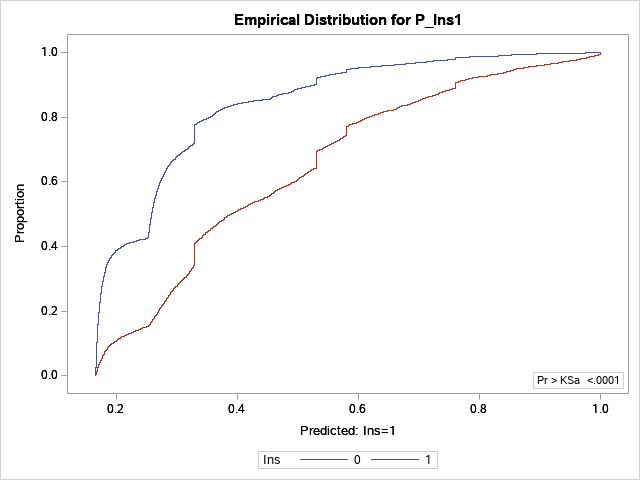
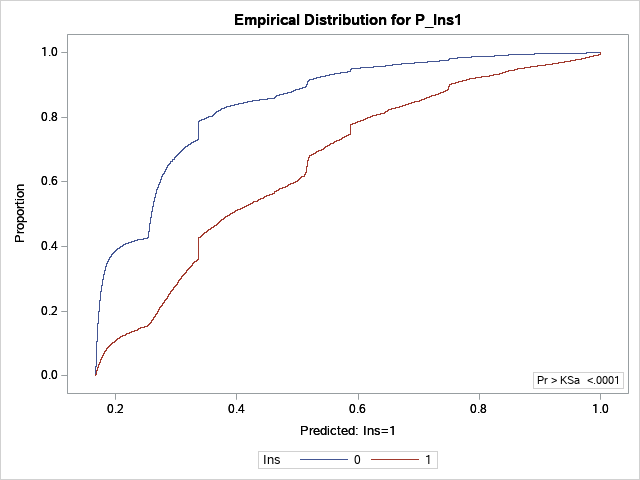

In [47]:
proc npar1way edf data=res1;
   class ins;
   var P_Ins1;
   title "K-S Statistic for the Validation Data Set";
run;

proc npar1way edf data=res2;
   class ins;
   var P_Ins1;
   title "K-S Statistic for the Validation Data Set";
run;


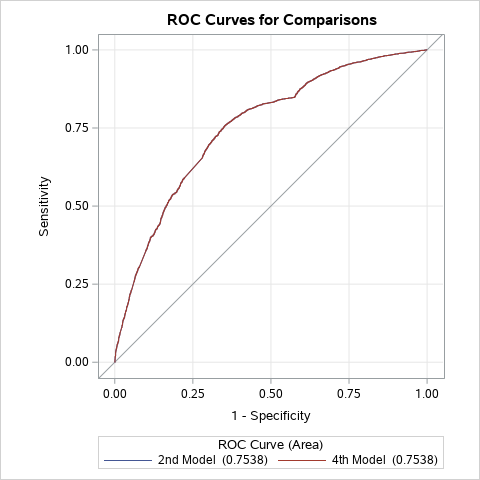

In [68]:
proc logistic data=train noprint;
   model ins(event='1')=DDA DDABal Sav SavBal CD MM;
   score data=test out=sco_validate(rename=(p_1=p_ch2));         
run;

proc logistic data=train noprint;
   model ins(event='1')=DDA DDABal Sav SavBal CD MM;
   score data=sco_validate out=sco_validate(rename=(p_1=p_sel));         
run;

ods select ROCOverlay ROCAssociation ROCContrastTest;
proc logistic data=sco_validate;
   model ins(event='1')=p_ch2 p_sel / nofit;
   roc "2nd Model" p_ch2;
   roc "4th Model" p_sel;
   roccontrast "Comparing the Two Models";
   title "Validation Data Set Performance";
run;


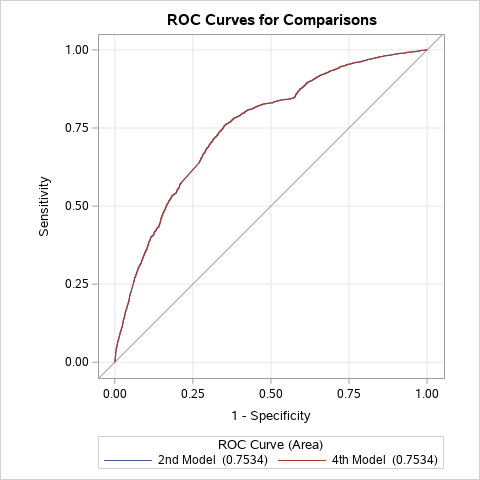

In [69]:
proc logistic data=train noprint;
   model ins(event='1')=DDA DDABal Sav SavBal CD MMBal;
   score data=test out=sco_validate(rename=(p_1=p_ch2));         
run;

proc logistic data=train noprint;
   model ins(event='1')=DDA DDABal Sav SavBal CD MMBal;
   score data=sco_validate out=sco_validate(rename=(p_1=p_sel));         
run;

ods select ROCOverlay ROCAssociation ROCContrastTest;
proc logistic data=sco_validate;
   model ins(event='1')=p_ch2 p_sel / nofit;
   roc "2nd Model" p_ch2;
   roc "4th Model" p_sel;
   roccontrast "Comparing the Two Models";
   title "Validation Data Set Performance";
run;

#### Q2.3 Все ли коэффициенты в обеих моделях значимые?
...

Не все: переменные DDABal, SavBal, MMBal оказались незначимыми.

#### Q2.4 Модели устойчивы? Как вы пришли к такому выводу? Какие шаги вы бы предложили предпринять для дальнейшего повышения устойчивости моделей?
... 

Модель не устойчива - разброс коэффициентов значимых переменных превышает 5% (из выводов построенных моделей).
Для повышения устойчивости модели неоходимо уменьшить дисперсию ее предикторов. Для этого можно увеличить размер выборки.
#### Q2.5 Чему равен индекс Джини для обеих моделей на train и test?
... 

0.7538 на первой, 0.7534 на второй